<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import build_montages
from sklearn.utils import shuffle 
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [0]:
tf.random.set_seed(42)
%matplotlib inline

In [0]:
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [0]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float") - 127.5) / 127.5

In [0]:
latent_dim = 100
height = 28
width = 28
nb_channels = 1

In [0]:
# Generator
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=latent_dim, units=512))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same"))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(nb_channels, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [0]:
generator = generator_network()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

In [0]:
# Discriminator
def disc_network():
    disc = Sequential()
    inputShape = (height, width, nb_channels)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    disc.add(Activation("sigmoid"))
    
    return disc

In [0]:
disc = disc_network()
disc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

In [0]:
disc_opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
disc.compile(optimizer=disc_opt, loss="binary_crossentropy")

In [0]:
# GAN
disc.trainable = False
gan_input = Input(shape=(latent_dim, ))
gan_output = disc(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
gan.compile(loss="binary_crossentropy", optimizer=gan_opt)

In [0]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1727233   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1658753   
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


In [0]:
disc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

In [0]:
epochs = 10000
batch_size = 20

In [0]:
start = 0
for epoch in tqdm(range(epochs)):
    # Sample random noise from a normal distribution
    benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
    # Map this noise to images via the generator network
    generated_images = generator.predict(benchmark_noise)
    
    # Calculate where to stop the current epoch, segregate the current batch
    # of real images and combine them with the fake ones
    stop = start + batch_size
    real_images = trainImages[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 1 -> Fake images, 0 -> Real images
    # Add a bit of random noise to the labels
    labels = np.array(([1] * batch_size) + ([0] * batch_size)).astype("float")
    labels += 0.05 * np.random.random(labels.shape)
    
    # Shuffle the datapoints of the newly created dataset
    (combined_images, labels) = shuffle(combined_images, labels)
    
    # Train the discriminator on these new dataset
    d_loss = disc.train_on_batch(combined_images, labels)
    
    # Again sample random noise from a normal distribution &
    # set the labels to such that they resemble real images to fool
    # discriminator
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    fake_labels = np.array([0] * batch_size)
    
    # Train the GAN with this random noise and fake labels, but only
    # update the weights of generator
    a_loss = gan.train_on_batch(random_latent_vectors, fake_labels)
    
    # Set the next batch
    start += batch_size
    if start > len(trainImages) - batch_size:
        start = 0
    
    # Logging
    if epoch % 500 == 0:
        print(f"Step: {epoch} Disc Loss: {d_loss} Adv Loss: {a_loss}")
        images = ((generated_images * 127.5) + 127.5).astype("int")
        images = np.repeat(images, 3, axis=-1)
        vis = build_montages(images, (28, 28), (4, 5))[0]
        cv2.imwrite("vis" + str(epoch) + ".png", vis)

  0%|          | 4/10000 [00:05<10:03:27,  3.62s/it]

Step: 0 Disc Loss: 0.6991685032844543 Adv Loss: 0.15844307839870453


  5%|▌         | 507/10000 [00:21<05:17, 29.86it/s]

Step: 500 Disc Loss: 0.5046908259391785 Adv Loss: 0.9750447273254395


 10%|█         | 1006/10000 [00:38<05:18, 28.28it/s]

Step: 1000 Disc Loss: 0.5820327997207642 Adv Loss: 1.829833984375


 15%|█▌        | 1506/10000 [00:54<04:49, 29.31it/s]

Step: 1500 Disc Loss: 0.5375659465789795 Adv Loss: 1.6481845378875732


 20%|██        | 2007/10000 [01:11<04:13, 31.54it/s]

Step: 2000 Disc Loss: 0.42668160796165466 Adv Loss: 1.9152504205703735


 25%|██▌       | 2504/10000 [01:28<04:18, 28.99it/s]

Step: 2500 Disc Loss: 0.34985268115997314 Adv Loss: 3.4861578941345215


 30%|███       | 3004/10000 [01:44<03:54, 29.79it/s]

Step: 3000 Disc Loss: 0.40786147117614746 Adv Loss: 2.300001621246338


 35%|███▌      | 3505/10000 [02:01<03:27, 31.32it/s]

Step: 3500 Disc Loss: 0.21770362555980682 Adv Loss: 2.9143998622894287


 40%|████      | 4004/10000 [02:17<03:13, 31.00it/s]

Step: 4000 Disc Loss: 0.444327175617218 Adv Loss: 1.7099872827529907


 45%|████▌     | 4505/10000 [02:34<03:00, 30.48it/s]

Step: 4500 Disc Loss: 0.3767152726650238 Adv Loss: 2.1596970558166504


 50%|█████     | 5006/10000 [02:50<02:47, 29.82it/s]

Step: 5000 Disc Loss: 0.30092671513557434 Adv Loss: 2.5903656482696533


 55%|█████▌    | 5506/10000 [03:07<02:24, 31.06it/s]

Step: 5500 Disc Loss: 0.4961828291416168 Adv Loss: 3.1493122577667236


 60%|██████    | 6005/10000 [03:23<02:12, 30.04it/s]

Step: 6000 Disc Loss: 0.2980179786682129 Adv Loss: 2.5176684856414795


 65%|██████▌   | 6505/10000 [03:40<01:54, 30.44it/s]

Step: 6500 Disc Loss: 0.34788018465042114 Adv Loss: 2.0999114513397217


 70%|███████   | 7004/10000 [03:56<01:36, 31.01it/s]

Step: 7000 Disc Loss: 0.3314719498157501 Adv Loss: 2.616029739379883


 75%|███████▌  | 7505/10000 [04:13<01:18, 31.60it/s]

Step: 7500 Disc Loss: 0.6641215085983276 Adv Loss: 3.156559705734253


 80%|████████  | 8003/10000 [04:29<01:05, 30.32it/s]

Step: 8000 Disc Loss: 0.6187286376953125 Adv Loss: 2.8449575901031494


 85%|████████▌ | 8505/10000 [04:46<00:47, 31.56it/s]

Step: 8500 Disc Loss: 0.208227276802063 Adv Loss: 2.068176746368408


 90%|█████████ | 9005/10000 [05:01<00:31, 31.76it/s]

Step: 9000 Disc Loss: 0.33300063014030457 Adv Loss: 1.847934365272522


 95%|█████████▌| 9506/10000 [05:17<00:15, 31.78it/s]

Step: 9500 Disc Loss: 0.3657732605934143 Adv Loss: 1.3273791074752808


100%|██████████| 10000/10000 [05:33<00:00, 30.01it/s]


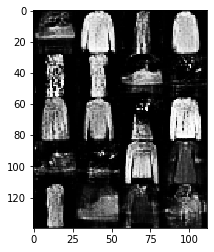

In [0]:
montage_1 =  plt.imread("vis5000.png")
plt.imshow(montage_1)
plt.show()

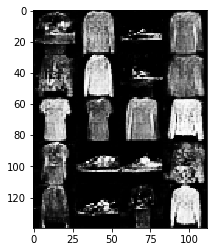

In [0]:
montage_2 =  plt.imread("vis4000.png")
plt.imshow(montage_2)
plt.show()